<a href="https://colab.research.google.com/github/BLonggg608/Card_Classification/blob/main/cardClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

### Step 1: Dataset

In [ ]:
class CardDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
torch.cuda.is_available()

True

In [ ]:
dataset = CardDataset(data_dir='/content/drive/MyDrive/CardClassfication/dataset/train')

In [ ]:
len(dataset)

7624

0


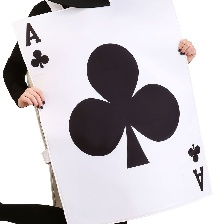

In [ ]:
image, label = dataset[0]
print(label)
image

In [ ]:
data_dir = '/content/drive/MyDrive/CardClassfication/dataset/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
target_to_class

{0: 'ace of clubs',
 1: 'ace of diamonds',
 2: 'ace of hearts',
 3: 'ace of spades',
 4: 'eight of clubs',
 5: 'eight of diamonds',
 6: 'eight of hearts',
 7: 'eight of spades',
 8: 'five of clubs',
 9: 'five of diamonds',
 10: 'five of hearts',
 11: 'five of spades',
 12: 'four of clubs',
 13: 'four of diamonds',
 14: 'four of hearts',
 15: 'four of spades',
 16: 'jack of clubs',
 17: 'jack of diamonds',
 18: 'jack of hearts',
 19: 'jack of spades',
 20: 'joker',
 21: 'king of clubs',
 22: 'king of diamonds',
 23: 'king of hearts',
 24: 'king of spades',
 25: 'nine of clubs',
 26: 'nine of diamonds',
 27: 'nine of hearts',
 28: 'nine of spades',
 29: 'queen of clubs',
 30: 'queen of diamonds',
 31: 'queen of hearts',
 32: 'queen of spades',
 33: 'seven of clubs',
 34: 'seven of diamonds',
 35: 'seven of hearts',
 36: 'seven of spades',
 37: 'six of clubs',
 38: 'six of diamonds',
 39: 'six of hearts',
 40: 'six of spades',
 41: 'ten of clubs',
 42: 'ten of diamonds',
 43: 'ten of hear

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = CardDataset(data_dir=data_dir, transform=transform)

In [ ]:
image, label = dataset[0]
image.shape

torch.Size([3, 128, 128])

In [ ]:
# iterate over dataset
for image, label in tqdm(dataset):
  break

  0%|          | 0/7624 [00:00<?, ?it/s]

DataLoaders

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
for images, labels in dataloader:
  break

In [ ]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [ ]:
labels

tensor([48, 52, 34, 23, 27, 18, 17, 47,  1, 47, 21,  6, 46, 33, 52, 12, 51,  2,
        19, 24, 14, 38, 15, 25, 31, 12, 45, 21,  1, 30, 17,  6])

###Step 2: Pytorch Model

In [ ]:
class CardClassifier(nn.Module):
  def __init__(self, num_classes=53):
    super(CardClassifier, self).__init__()

    # define all the parts of the model
    self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])
    enet_out_size = 1280

    # make a classifier
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(enet_out_size, num_classes)
    )

  def forward(self, x):
    # connect these parts and return the output
    x = self.features(x)
    output = self.classifier(x)
    return output

In [ ]:
model = CardClassifier(num_classes=53)
print(str(model)[:500])

CardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
 


In [ ]:
example_output = model(images)
example_output.shape

torch.Size([32, 53])

###Step 3: Training loop

In [ ]:
# loss fucntion
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
criterion(example_output, labels)
print(example_output.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


Setup Dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/content/drive/MyDrive/CardClassfication/dataset/train'
valid_folder = '/content/drive/MyDrive/CardClassfication/dataset/valid'
test_folder = '/content/drive/MyDrive/CardClassfication/dataset/test'

train_dataset = CardDataset(train_folder, transform=transform)
val_dataset = CardDataset(valid_folder, transform=transform)
test_dataset = CardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Training loop

In [ ]:
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
  # Training phase
  model.train()
  running_loss = 0.0
  for images, labels in tqdm(train_loader, desc='Training loop'):
    # Move inputs and labels to the device
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * labels.size(0)
  train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(train_loss)

  # Validation phase
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Validation loop'):
      # Move inputs and labels to the device
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * labels.size(0)
  val_loss = running_loss / len(val_loader.dataset)
  val_losses.append(val_loss)
  print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.51813634395099, Validation loss: 0.39216671889682986


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5209309445598318, Validation loss: 0.3055752729469875


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.33539312935638527, Validation loss: 0.28899494791930574


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.24914766332097468, Validation loss: 0.18788135546558307


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.1756725176340135, Validation loss: 0.15208926448282206


Visualize losses

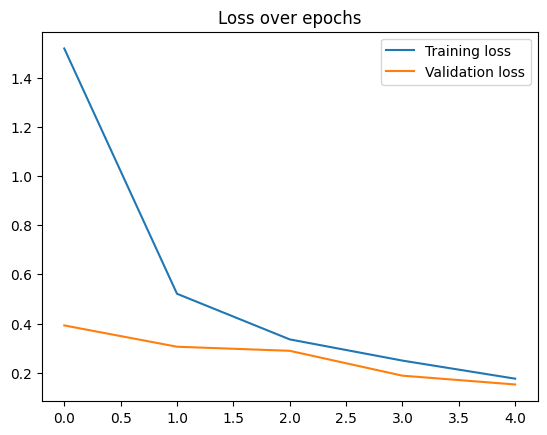

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

###Step 4: Evaluation

In [ ]:
from PIL import Image

# Load and preprocess the image
def preprocess_image(image_path, transform):
  image = Image.open(image_path).convert("RGB")
  return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
  model.eval()
  with torch.no_grad():
    image_tensor = image_tensor.to(device)
    outputs = model(image_tensor)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
  return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
  fig, axarr = plt.subplots(1, 2, figsize=(10, 7))

  # Display image
  axarr[0].imshow(original_image)
  axarr[0].axis("off")

  # Display predictions
  axarr[1].barh(class_names, probabilities)
  axarr[1].set_xlabel("Probability")
  axarr[1].set_title("Class Predictions")
  axarr[1].set_xlim(0, 1)

  plt.tight_layout()
  plt.show()

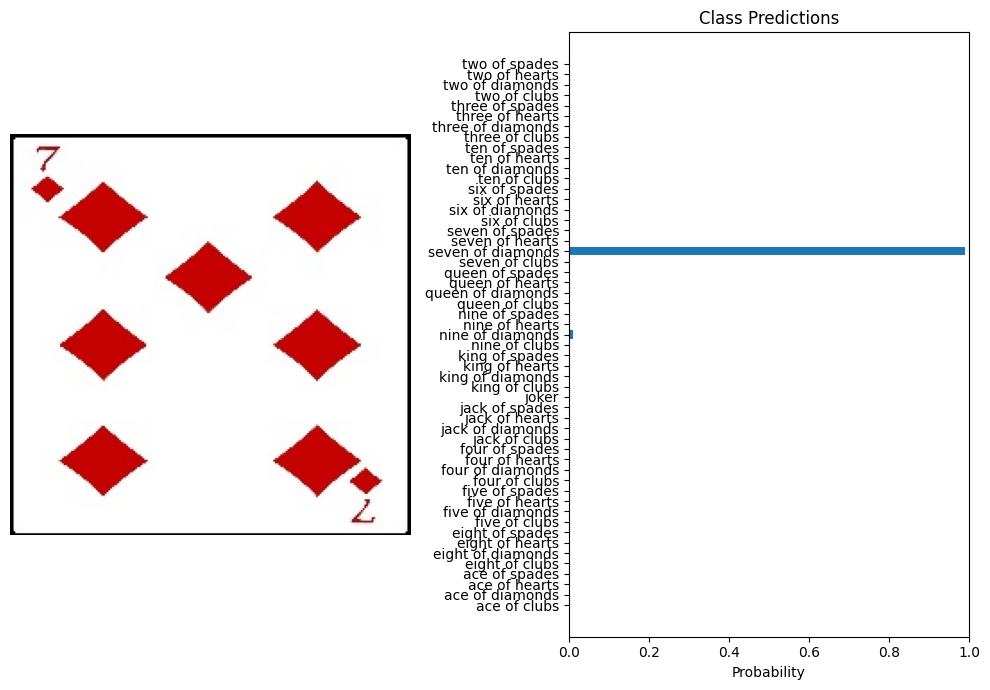

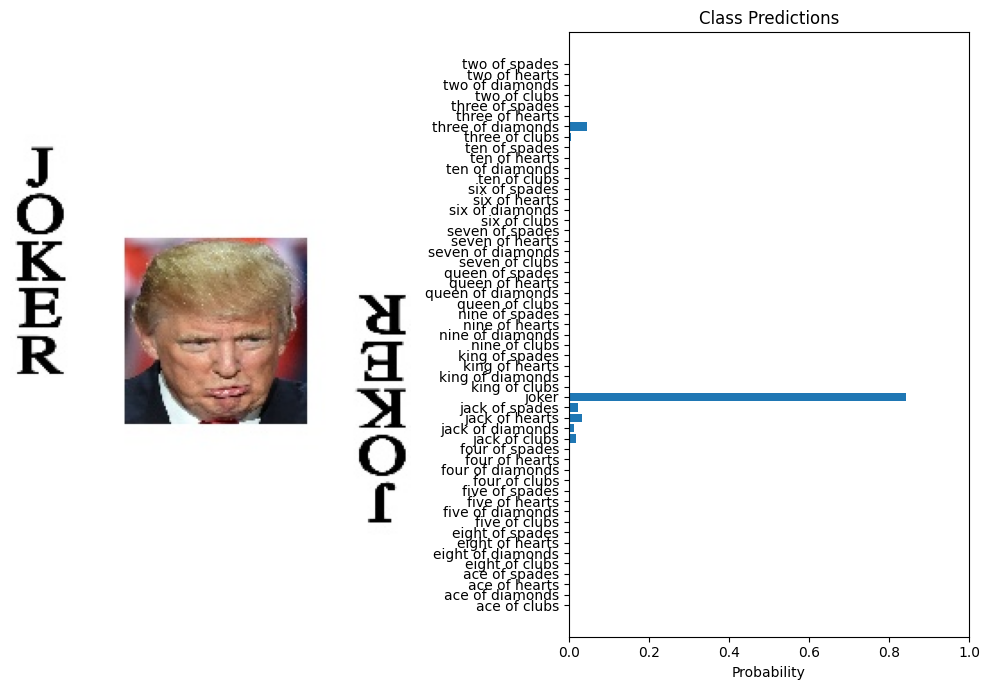

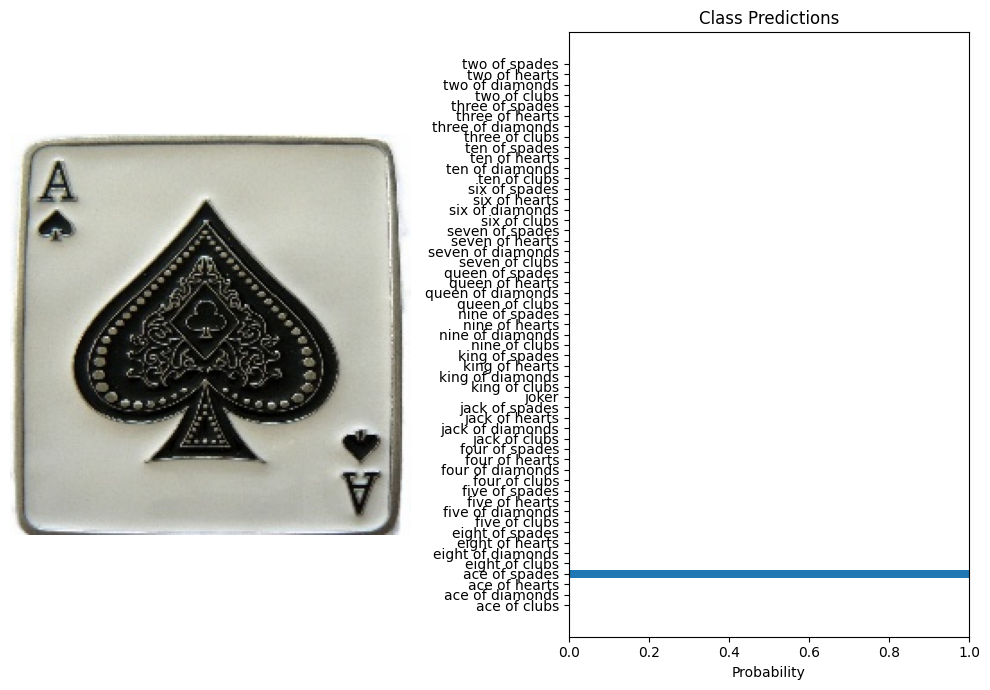

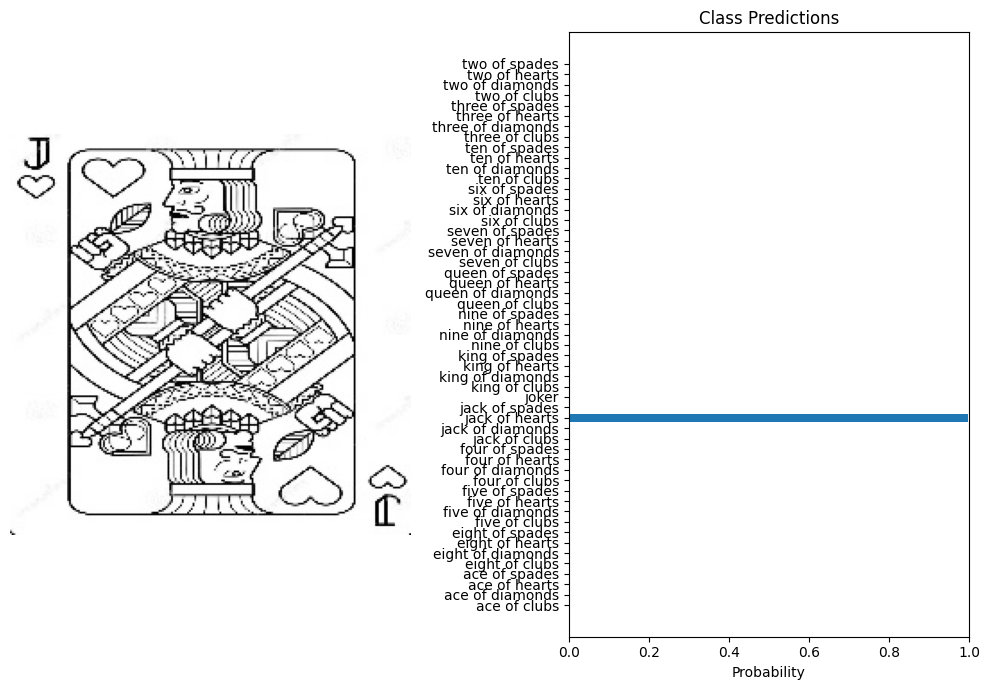

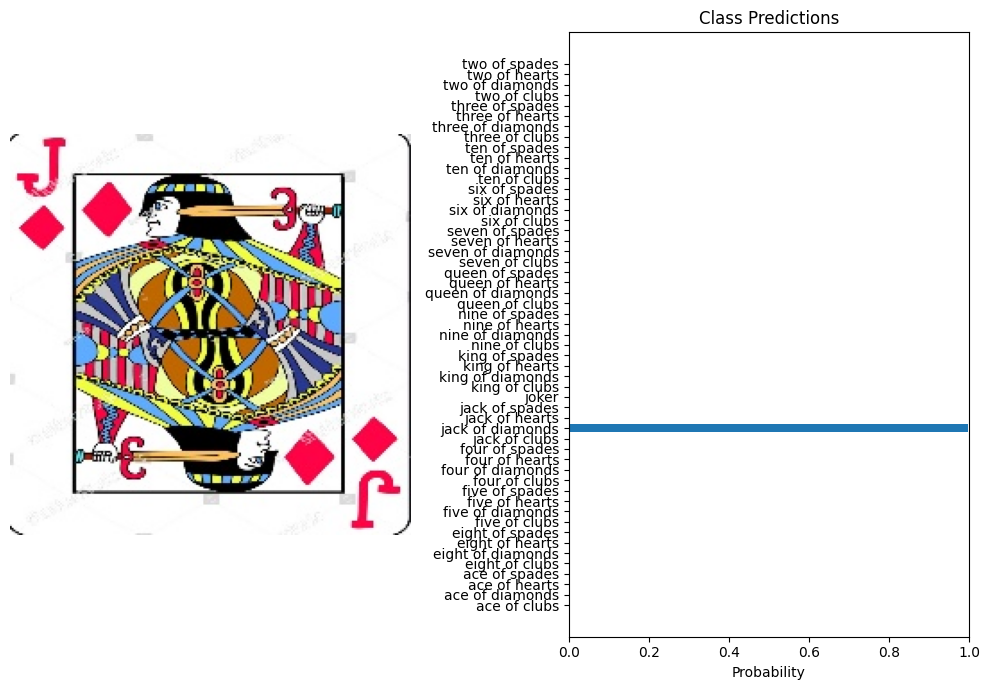

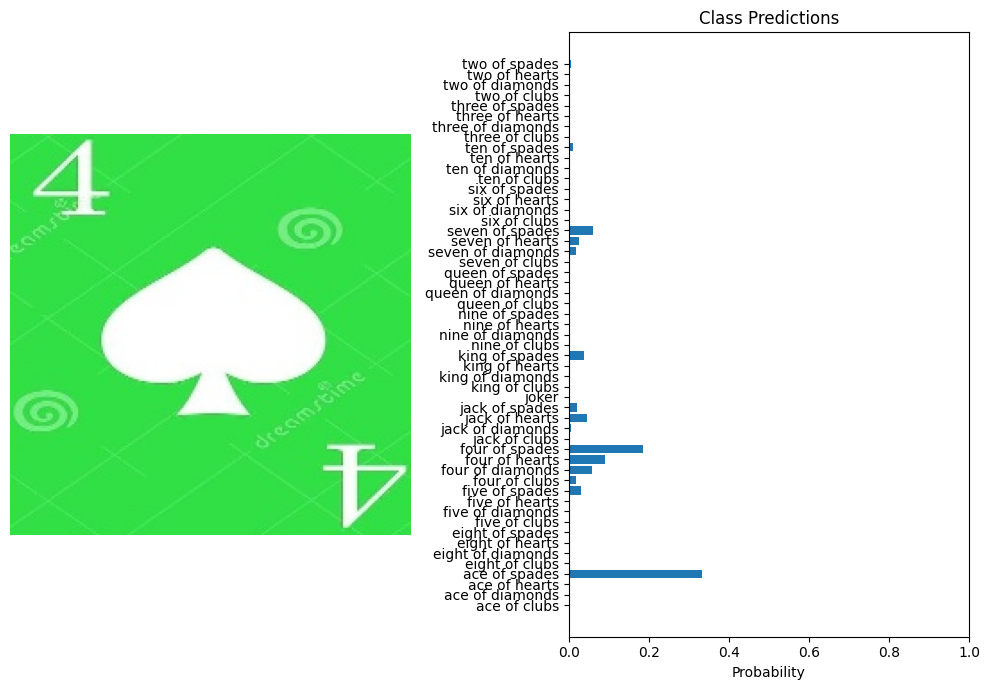

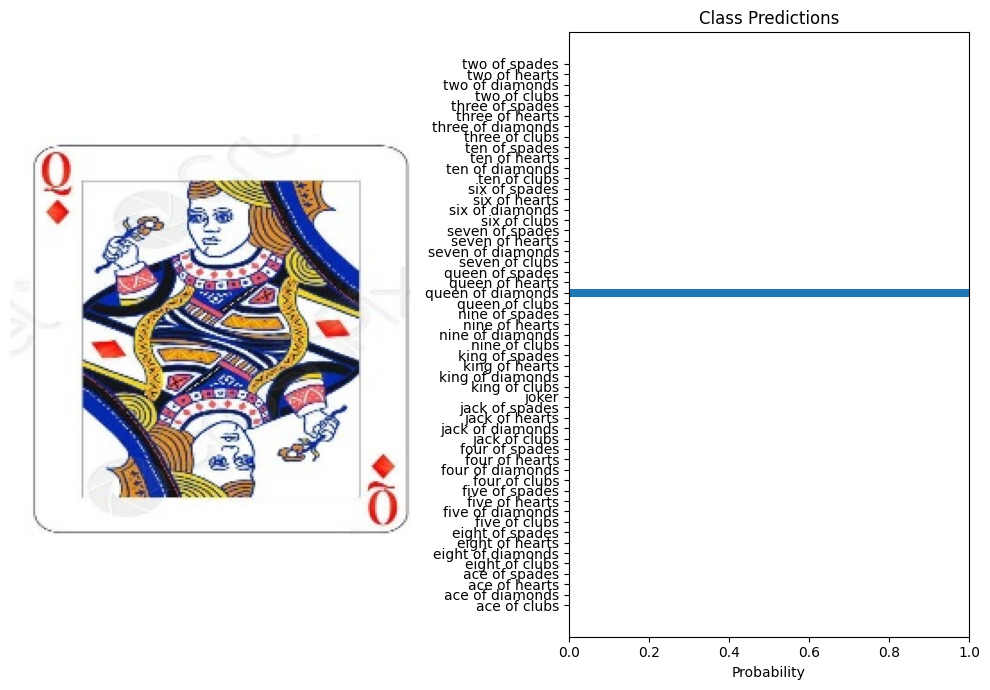

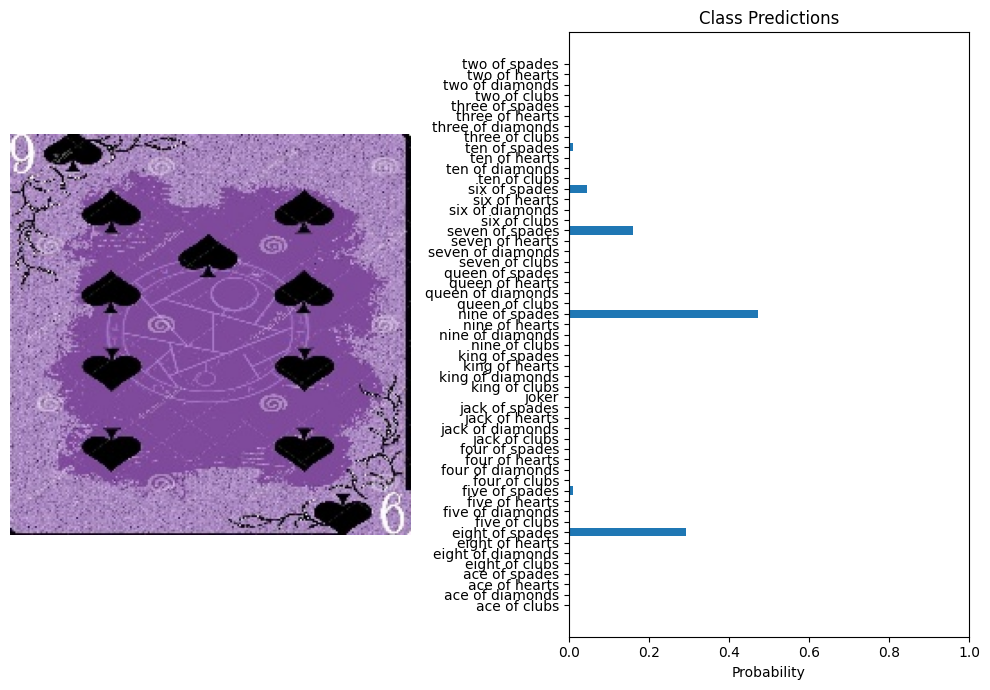

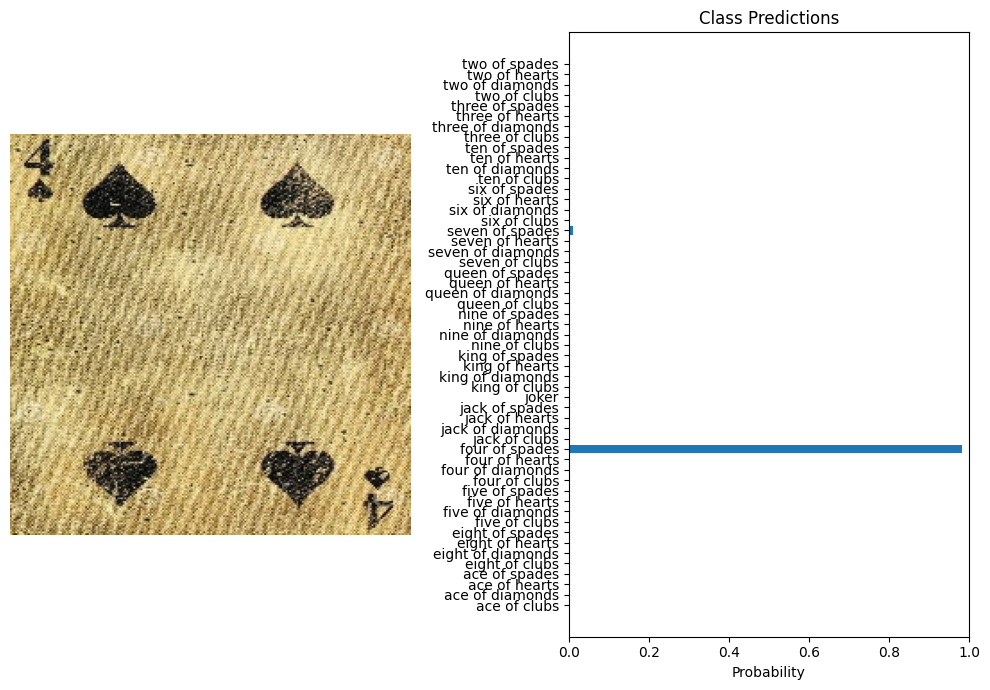

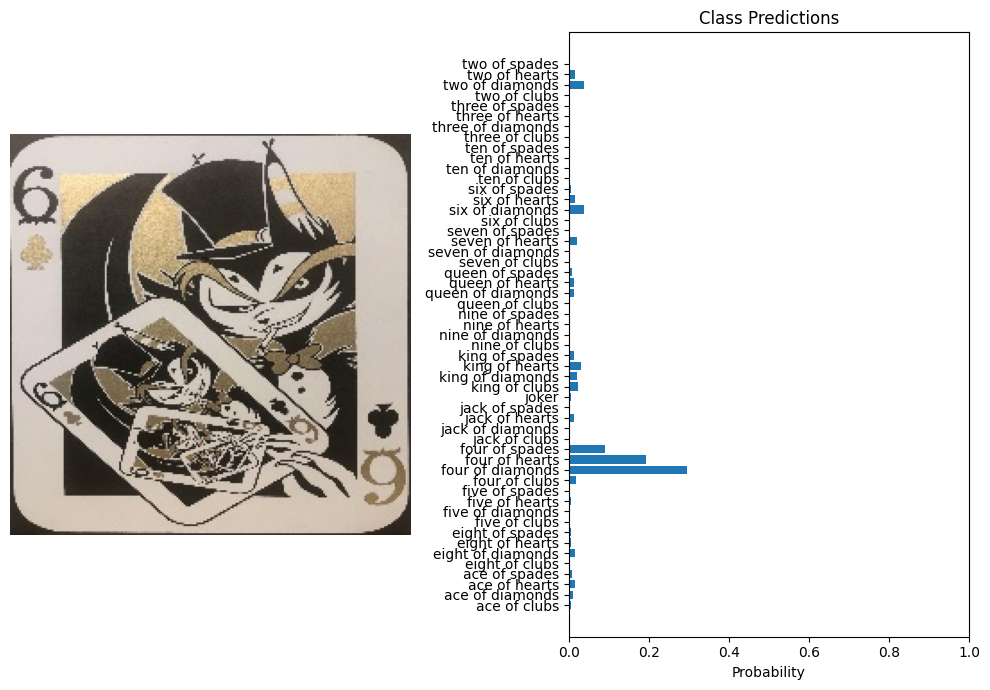

In [ ]:
from glob import glob
test_images = glob('/content/drive/MyDrive/CardClassfication/dataset/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
  original_image, image_tensor = preprocess_image(example, transform)
  probabilities = predict(model, image_tensor, device)

  # Assuming dataset.classes gives the class names
  class_names = dataset.data.classes
  visualize_predictions(original_image, probabilities, class_names)

In [ ]:
accuracy = 0
for image_tensor, label in tqdm(test_dataset):
    probabilities = predict(model, image_tensor.unsqueeze(0), device)
    if np.argmax(probabilities) == label:
        accuracy += 1

accuracy = accuracy / len(test_dataset)


  0%|          | 0/265 [00:00<?, ?it/s]

In [ ]:
accuracy

0.9283018867924528